# Investigate a Dataset: Titanic Data

## 1. Introduction

In this report, I will investigate the Titanic survivor data using exploratory data analysis.

In the data wrangling phase, I will determine the appropriate datatypes for our dataset, and I will also show how to handle missing values. 

In the data exploration phase, I will first look at each variable and its distribution. After that, I will answer two question:

1. What factors make people more likely to survive?

2. What money can buy? -- Explore relations among passenger class, cabin, and fare. 

Last, I will conclude this report by summarizing the findings and stating the limitations of my analysis.

# 2 Data Wrangling

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
# Change figure size into 8 by 6 inches
matplotlib.rcParams['figure.figsize'] = (8, 6)

Populating the interactive namespace from numpy and matplotlib


### 2.1 Handling Data Types

After reviewing the original description of the dataset from [the Kaggle website](https://www.kaggle.com/c/titanic/data), the data type of each variable is chosen as following, and categorical variables will be converted to more descriptive labels:

| Variable | Definition                                 | Key                                            | Type            |
|----------|--------------------------------------------|------------------------------------------------|-----------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                | int (Survived)* |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | int (Class)     |
| Sex      | Sex                                        |                                                | str             |
| Age      | Age in years                               |                                                | float           |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                | int             |
| ParCh    | # of parents / children aboard the Titanic |                                                | int             |
| Ticket   | Ticket number                              |                                                | int             |
| Fare     | Passenger fare                             |                                                | float           |
| Cabin    | Cabin number                               |                                                | str             |
| Embarked | Port of embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | str (Port)      |

\* indicate the name of converted categorical variable

In [4]:
data_file = 'titanic-data.csv'
titanic_df = pd.read_csv(
    data_file, 
    dtype = {'PassengerId': str}
)

In [6]:
# Convert categorical variables to more descriptive labels.

# Create descriptive Survival column from Survived column
titanic_df['Survival'] = titanic_df['Survived'].map({0: 'Died', 
                                                     1: 'Survived'})

# Create descriptive Class column from Pclass column 
titanic_df['Class'] = titanic_df['Pclass'].map({1: 'First Class', 
                                                2: 'Second Class', 
                                                3: 'Third Class'})

# Create descriptive Port column from Embarked column
titanic_df['Port'] = titanic_df['Embarked'].map({'C': 'Cherbourg', 
                                                 'Q': 'Queenstown', 
                                                 'S': 'Southampton'})

### 2.2 Handling Missing Values

In [12]:
total_passengers = len(titanic_df)
print("There are {} passengers on board.".format(total_passengers))

There are 891 passengers on board.


In [13]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
ParCh            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survival         0
Class            0
Port             2
dtype: int64

There are three columns with missing values: Age, Cabin, and Embarked(Port).

#### 2.2.1 Age

There are 117 out of 891 passengers missing Age values. Because filling in the missing Age values will affect the distribution of Age variable, and this analysis is mainly exploratory, I will **drop rows with missing Age values**.

But as an exercise, I will show here a way of filling in the missing Age values based on the assumption that Age values can be infered from SibSp, ParCh, Class, and Sex.

We'll store the filled Age values in a new column called AgeFilled.

In [18]:
titanic_df['AgeFilled'] = titanic_df['Age']

##### SibSp and ParCh

SibSp(number of siblings/spouses): The number of spouses can only be 0 or 1, therefore any SibSp value greater than 1 can be implied that this person is traveling with sibling(s).

ParCh(number of parents/children): The number of parents can only be 2 maximum, any ParCh value greater than 2 can be implied that this person is traveling with child(ren).

From these two observations, we can infer two rules:

1. If SibSp >= 2, this passenger has at least 1 sibling on board, and if also his/her ParCh >= 1, then he/she is most likly a **child** traveling with sibling(s) and parent(s).

2. If Parch >= 3, this passenger has at least 1 child, then he/she has to be an **adult** parent traveling with child(ren).

From these two rules, we can divide all rows into three categories: **Child**, **Adult**, **Unknown**, and store this categorical value in a new column ChAd. And we can fill in the Age value of the row categoried with child or parent with its category's median age value.

In [14]:
def child_or_adult(sibsp, parch):
    '''Categorize a person as Child, Adult or Unknown
    
    Arg:
    sibsp: the number of siblings/spouses
    parch: the number of parents/children
    
    Return:
    A string denotes Child, Adult or Unknown
    '''
    if sibsp >= 2 and parch >= 1:
        return 'Child'
    if parch >= 3:
        return 'Adult'
    return 'Unknown'

In [17]:
titanic_df['ChAd'] = titanic_df[['SibSp', 'ParCh']].apply(lambda x: child_or_adult(*x), axis=1)

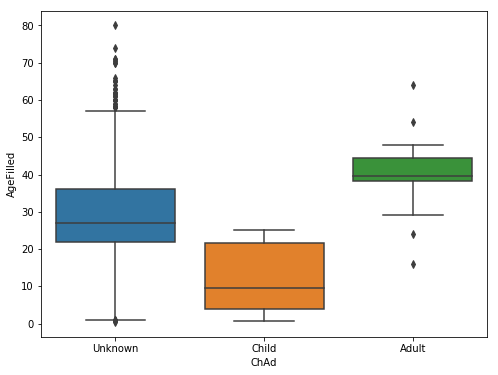

In [73]:
sns.boxplot(x='ChAd', y='AgeFilled', data=titanic_df)

Fill Adult, Child groups' missing Age values with groups' median values. Leave Unknown group' missing Age values as NaN.

In [23]:
for group_name, group in titanic_df.groupby('ChAd'):
    if group_name == 'Adult' or group_name == 'Child':
        group['AgeFilled'].fillna(group['AgeFilled'].median())

##### Class and Sex

For the passengers categorized as Unknown in the ChAd column, I will fill the missing Age values with the median value of the same Class and Sex group.

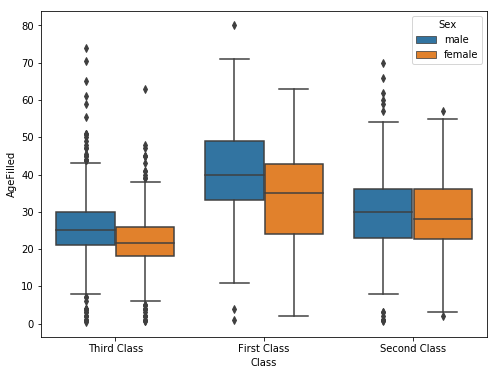

In [74]:
sns.boxplot(x='Class', y='AgeFilled', hue='Sex', data=titanic_df)

In [28]:
fillna_with_median = lambda x: x.fillna(x.median(), inplace=False)
titanic_df['AgeFilled'] = titanic_df.groupby(['Sex', 'Pclass'])['AgeFilled'].transform(fillna_with_median)

I will look at how the distribution of Age has changed after filling the missing values in the next section.

#### 2.2.2 Cabin

There are 689 out of 891 passengers missing Cabin values. Because the majority of rows are missing cabin values, I decide to exclude these rows during analysis when cabin value is considered.

#### 2.2.3 Embarked (Port)

There are 2 out of 891 passengers missing Embarked values. Here I choose to fill these two missing values with the most frequent value (mode).

In [29]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode().iloc[0]);
titanic_df['Port'] = titanic_df['Port'].fillna(titanic_df['Port'].mode().iloc[0]);

## Data Exploration 1: Initial Examination of Single Variables

For the first exploration phase, I will look at some of the variables individually.

In [104]:
def categorical_count_and_frequency(series):
    '''Calculate count and frequency table
    
    Given an categorical variable pandas Series, return a DataFrame containing
    counts and frequencies of each possible value.
    
    Arg:
    series: A pandas Series from a categorical variable
    
    Returns:
    A DataFrame containing counts and frequencies
    '''
    
    counts = series.value_counts()
    frequencies = series.value_counts(normalize=True)
    return counts.to_frame(name='Counts').join(frequencies.to_frame(name='Frequencies')).sort_index()

### 3.1 Survival

In [105]:
categorical_count_and_frequency(titanic_df['Survival'])

,Counts,Frequencies
Died,549,0.616162
Survived,342,0.383838


Out of 891 passengers, there are 342 of them survived, and 549 died. The overall survival rate is about 38.3%

### 3.2 Class

In [106]:
categorical_count_and_frequency(titanic_df['Class'])

,Counts,Frequencies
First Class,216,0.242424
Second Class,184,0.206510
Third Class,491,0.551066


There are 216 first class ticket passengers (24%), 184 second class ticket passengers (21%), and 491 third class ticket passengers (55%).

### 3.3 Sex

In [107]:
categorical_count_and_frequency(titanic_df['Sex'])

,Counts,Frequencies
female,314,0.352413
male,577,0.647587


There are 577 male passengers (65%) and 314 female passengers (35%).

### 3.4 Age

In [38]:
titanic_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

([<matplotlib.axis.XTick at 0x11abfc780>,
 <a list of 9 Text xticklabel objects>)

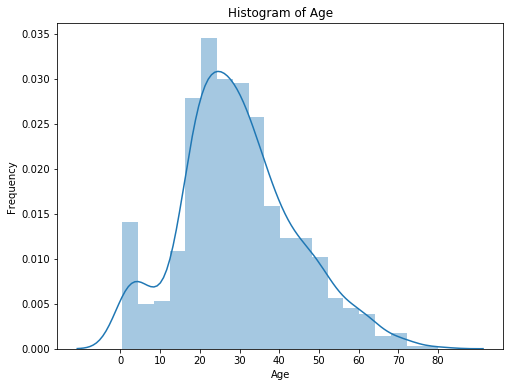

In [75]:
ax = sns.distplot(titanic_df['Age'].dropna())
ax.set_title('Histogram of Age')
ax.set_ylabel('Frequency')
plt.xticks(linspace(0, 80, 9))

The age distribution is bimodal. One mode is centered around 5 years old representing children. The other mode is positively skewed with a peak between 20 and 30 representing teenagers and adults.

I will also take look at the age distribtion with missing values filled from the previous section.

([<matplotlib.axis.YTick at 0x11aea9d68>,
 <a list of 14 Text yticklabel objects>)

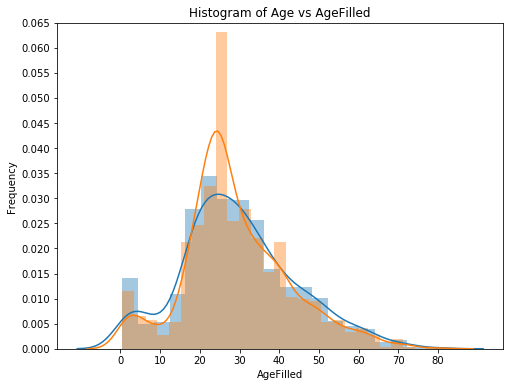

In [76]:
sns.distplot(titanic_df['Age'].dropna())
ax = sns.distplot(titanic_df['AgeFilled'].dropna())
ax.set_title('Histogram of Age vs AgeFilled')
ax.set_ylabel('Frequency')
plt.xticks(np.linspace(0, 80, 9))
plt.yticks(np.linspace(0, 0.065, 14))

Comparing Age (blue) and AgeFilled (orange) histograms, one can clearly see that filling the Age missing values changed the distribution. Most of the Age values filled are concentrated around the largest peak of the original age distribution.

### 3.5 SibSp

In [108]:
categorical_count_and_frequency(titanic_df['SibSp'])

,Counts,Frequencies
0,608,0.682379
1,209,0.234568
2,28,0.031425
3,16,0.017957
4,18,0.020202
5,5,0.005612
8,7,0.007856


608 passengers (68%) travel without any sibling or spouse.

209 passengers (23%) passengers travel with only 1 sibling or spouse, and in this case, it is likely to be a spouse.

The remaining 74 passengers (9%) travel more than ! sibling or spouse, and in this case, it is like to be siblings.

### 3.6 ParCh

In [109]:
categorical_count_and_frequency(titanic_df['ParCh'])

,Counts,Frequencies
0,678,0.760943
1,118,0.132435
2,80,0.089787
3,5,0.005612
4,4,0.004489
5,5,0.005612
6,1,0.001122


678 passengers (76%) travel without any parent or child.

The remaining 213 passengers travel with 1 to 6 parent(s) or child(ren).

### 3.7 Fare

In [110]:
titanic_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

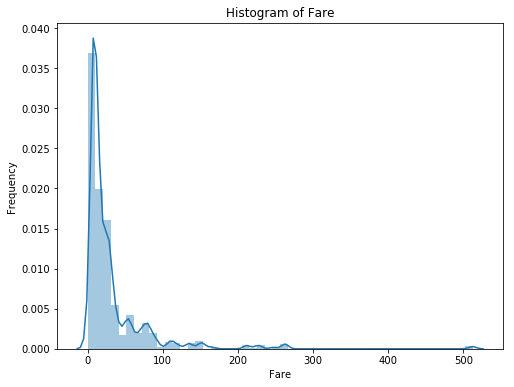

In [112]:
ax = sns.distplot(titanic_df['Fare'])
ax.set_title('Histogram of Fare')
ax.set_ylabel('Frequency')

From the historgram we can see the fare distribution is positively skewed.

### 3.8 Cabin

In [113]:
titanic_df['Cabin'].describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

Out of the 891 passengers on board, there are only 204 of them with their cabin information.

The cabin number can be interpreted as the following:
- The first letter indicating the cabin level.
- The following digits indicating the room number. 

For our analysis purpose, we are going to only look at the cabin level here for passengers with known cabin number, and keep NaN as NaN for passenger without any cabin number.

Add a column 'CabinLevel' that contains the cabin level (the first letter of 'Cabin' column).

In [114]:
titanic_df['CabinLevel'] = titanic_df['Cabin'].str[0]

In [115]:
categorical_count_and_frequency(titanic_df['CabinLevel'])

,Counts,Frequencies
A,15,0.073529
B,47,0.230392
C,59,0.289216
D,33,0.161765
E,32,0.156863
F,13,0.063725
G,4,0.019608
T,1,0.004902


### 3.9 Port

In [116]:
categorical_count_and_frequency(titanic_df['Port'])

,Counts,Frequencies
Cherbourg,168,0.188552
Queenstown,77,0.086420
Southampton,646,0.725028


After filling the 2 passengers who are missing their port of embarkation information, 168 (19%) boarded at Cherbourg, 77 (9%) boarded at Queenstown, and 646 (72%) boarded at Southampton.

## 4 Data Exploration 2: What factors make people more likely to survive?

In [118]:
def survival_by(variable_name):
    '''Calculate survival rate for a given variable
    
    For the titanic pandas DataFrame titanic_df, calculate the survival count and 
    survival rate grouped by a given categorical variable.
    
    Arg:
    variable_name: a categorical variable name to group by
    
    Return:
    survival_by_df: a pandas DataFrame that contains the total number of passengers,
        survivied number of passengers, and survival rate for each category of
        the given categorical variable
    '''
    
    grouped = titanic_df.groupby(variable_name)
    total = grouped.size() # number of total passengers by variable
    survived = grouped['Survived'].sum() # number of survived passengers by variable
    survival_rate = survived / total # survival rate by variable
    survival_by_df = pd.DataFrame(
        data = [total, survived, survival_rate], 
        index = ['Total', 'Survived', 'Survival Rate']
    )
    return survival_by_df

In [129]:
def survival_by_plot(survival_by_df):
    '''Plot a bar graph showing Survival Rate vs a categorical variable
    
    For the survial_by_df, a pandas DataFrame showing the survival count and survival rate
    for the titanic_df pandas DataFrame, this funcions plots a bar graph showing the
    survival rate across a given categorical variable.
    
    Arg:
    survival_by_df: a pandas DataFrame generated by the survival_by(variable_name) function.
    '''
    
    ax = survival_by_df.T['Survival Rate'].plot(kind = 'bar')
    ax.set_ylabel('Survival Rate')
    ax.set_title('Barplot of Survival Rate vs {}'.format(survival_by_df.columns.name))

### 4.1 Survived vs Class

In [133]:
survival_by_class_df = survival_by('Class')
survival_by_class_df

Class,First Class,Second Class,Third Class
Total,216.00000,184.000000,491.000000
Survived,136.00000,87.000000,119.000000
Survival Rate,0.62963,0.472826,0.242363


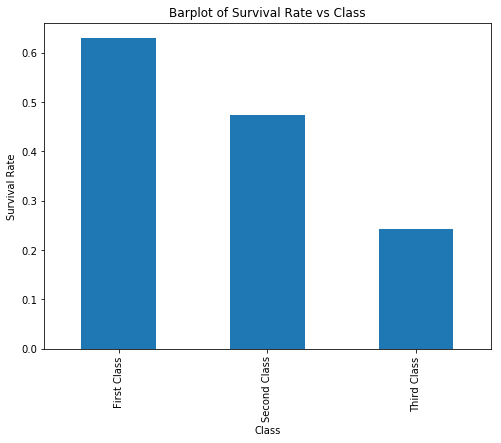

In [135]:
survival_by_plot(survival_by_class_df)

Class (passenger class) is an important factor that correlates with survival rate. 

First class passenger survival rate (63%) > second class passenger survival rate (47%) > third class passenger survival rate. 

Since Class is a proxy for socio-economic status (1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower), the result suggests that the higher your socio-economic status is, the higher your survival rate is.

### 4.2 Survived vs Sex

In [125]:
survival_by_sex_df = survival_by('Sex')
survival_by_sex_df

Sex,female,male
Total,314.000000,577.000000
Survived,233.000000,109.000000
Survival Rate,0.742038,0.188908


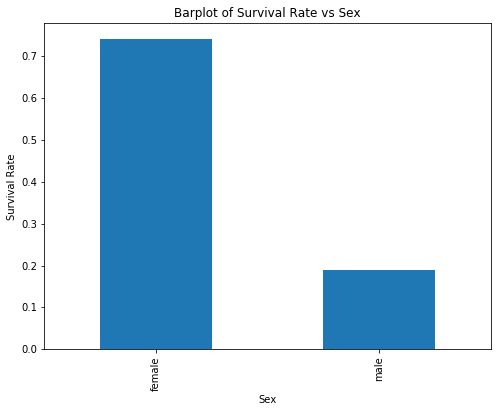

In [136]:
survival_by_plot(survival_by_sex_df)

Sex is one important factor that correlates with survival rate. Female survival rate (74%) is much higher than male survival rate (19%)

### 4.3 Survived vs Age

Because Age is a continuous variable, I need to convert it into descrete groups first. Here I choose Age groups in 10 year interval ranging from 0 to 80 in order to include all passgeners with Age values. These Age groups are stored in a new column called 'AgeGrp'

In [137]:
titanic_df['AgeGrp'] = pd.cut(
    titanic_df['Age'], 
    bins = np.linspace(0, 80, 9), 
    include_lowest = True
)

In [140]:
survival_by_age_df = survival_by('AgeGrp')
survival_by_age_df

AgeGrp,"(-0.001, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 60.0]","(60.0, 70.0]","(70.0, 80.0]"
Total,64.00000,115.000000,230.000000,155.000000,86.000000,42.000000,17.000000,5.0
Survived,38.00000,44.000000,84.000000,69.000000,33.000000,17.000000,4.000000,1.0
Survival Rate,0.59375,0.382609,0.365217,0.445161,0.383721,0.404762,0.235294,0.2


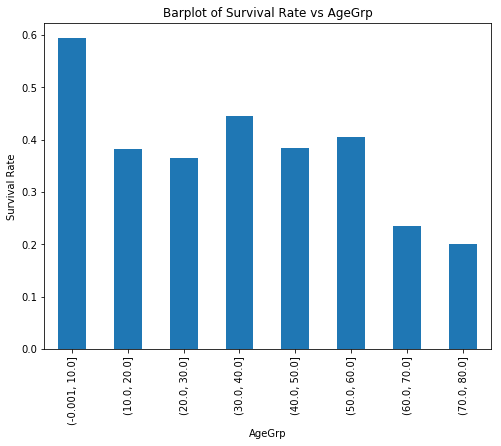

In [141]:
survival_by_plot(survival_by_age_df)

Young kids aged below 10 has a high survival rate close to 60%, old people aged above 60 has a low survival rate around 20%, and everyone else has a similar survival rate around 40%.

### 4.4 Survived vs SibSp

In [142]:
survival_by_sibsp_df = survival_by('SibSp')
survival_by_sibsp_df

SibSp,0,1,2,3,4,5,8
Total,608.000000,209.000000,28.000000,16.00,18.000000,5.0,7.0
Survived,210.000000,112.000000,13.000000,4.00,3.000000,0.0,0.0
Survival Rate,0.345395,0.535885,0.464286,0.25,0.166667,0.0,0.0


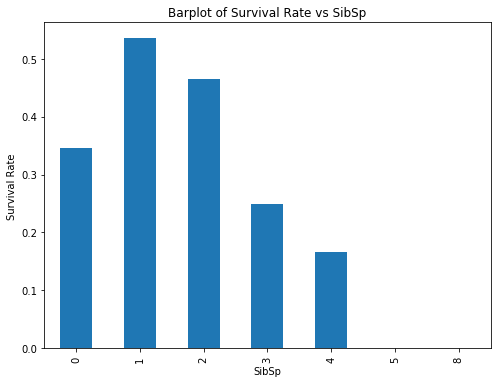

In [143]:
survival_by_plot(survival_by_sibsp_df)

Passengers who travel without any sibling/spouse has a survival rate around 35%, which is lower than the survival rate of passengers who travel with 1 (54%) or 2 (46%) siblings/spouses. The number of passengers who travel with 3 or more siblings/spouses is too small to draw any definitive conclusion.

### 4.5 Survived vs ParCh

In [144]:
survival_by_parch_df = survival_by('ParCh')
survival_by_parch_df

ParCh,0,1,2,3,4,5,6
Total,678.000000,118.000000,80.0,5.0,4.0,5.0,1.0
Survived,233.000000,65.000000,40.0,3.0,0.0,1.0,0.0
Survival Rate,0.343658,0.550847,0.5,0.6,0.0,0.2,0.0


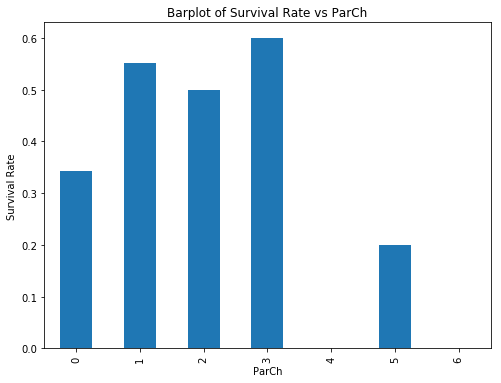

In [145]:
survival_by_plot(survival_by_parch_df)

Passengers who travel without any parent/child has a survival rate of 34%, which is lower than the survival rate of passengers who travel with 1 (55%) or 2 (50%) parents/children. The number of passengers who travel with 3 or more parents/children is too small to draw any definitive conclusion.

### 4.6 Survived vs Fare

As the histogram from previous section shows that the fare distribution is highly positively skewed. If we categorize fare into fare groups with fixed width bins, the low fare bin will end up with too many passengers while the high fare bin will only have very few passengers.

Here I decide to choose bins corresponding to quartiles, so that every bin has similar number of passengers. The quartile categorization is stored in a new column called 'FareGrp'.

In [146]:
titanic_df['FareGrp'] = pd.cut(
    titanic_df['Fare'], 
    bins = titanic_df['Fare'].quantile([0, 0.25, 0.5, 0.75, 1]), 
    labels = ['1Q', '2Q', '3Q', '4Q'], 
    include_lowest = True
)

In [147]:
survival_by_fare_df = survival_by('FareGrp')
survival_by_fare_df

FareGrp,1Q,2Q,3Q,4Q
Total,223.000000,224.000000,222.000000,222.000000
Survived,44.000000,68.000000,101.000000,129.000000
Survival Rate,0.197309,0.303571,0.454955,0.581081


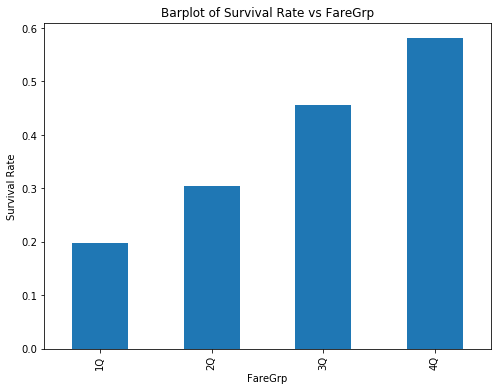

In [148]:
survival_by_plot(survival_by_fare_df)

From the bar plot one can clearly see that a higher fare correlates to a higher survival rate.

## 5 Data Exploration 3: What money can buy? Explore relations among passenger class, cabin, and fare

### 5.1 Class vs Fare

Because there're only 204 out of 891 passengers with Cabin information, we'll look at only 'Class' and 'Fare' first.

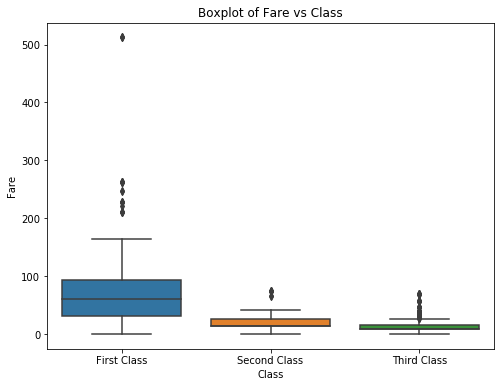

In [151]:
ax = sns.boxplot(x = 'Class', y = 'Fare', data = titanic_df, 
                 order=['First Class', 'Second Class', 'Third Class']);
ax.set_title('Boxplot of Fare vs Class')

In [152]:
titanic_df.groupby('Class')['Fare'].median()

Class
First Class     60.2875
Second Class    14.2500
Third Class      8.0500
Name: Fare, dtype: float64

The median First Class fare is about 4 times of the median Second Class fare, and the median Second Class fare is about 2 times of the median Third Class fare.

## 5.2 Carbin vs Fare vs Class

Now I will include Cabin into the analysis, and only include the 204 passengers with givin Cabin values.

Because the number of data points is not too large, I will use a swarmplot to show all data points and to look at all 3 variables at once.

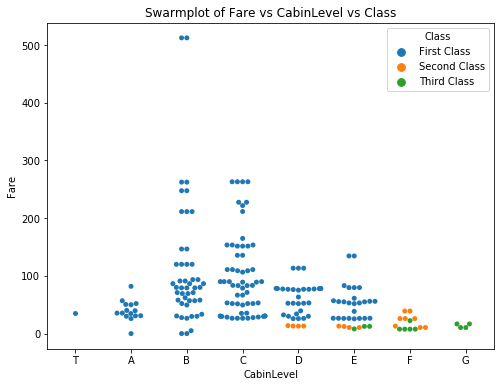

In [154]:
ax = sns.swarmplot(
    x = 'CabinLevel', 
    y = 'Fare', 
    hue = 'Class', 
    order = list('TABCDEFG'),
    hue_order = ['First Class', 'Second Class', 'Third Class'],
    data = titanic_df
)
ax.set_title('Swarmplot of Fare vs CabinLevel vs Class')

There are some interesting findings from this plot:

1. Most of the cabin numbers are recorded for First Class passengers, and very few Second and Third Class passengers have their cabin numbers on the record.
2. From the records, cabin level T, A, B and C are exclusively for First Class passengers, and cabin level F and G only accommodate Second and Third Class passengers.